In [ ]:
!git clone 

In [5]:
# ---------------------------
# Full CodeQL CWE Extraction and CSV Generation
# ---------------------------

import os
import json
import subprocess
import pandas as pd
from pathlib import Path
import re
import csv
import shutil

# ---------------------------
# Step 0: Configure paths
# ---------------------------
BASE_DIR = Path("C:/Users/taksh/sttlab6")
CODEQL_PATH = BASE_DIR / "codeql" / "codeql.exe"
CODEQL_QUERIES = Path("C:/Users/taksh/.codeql/packages/codeql/python-queries/1.6.6/codeql-suites/python-security-and-quality.qls")

# Repositories
REPOS = {
    "manim": BASE_DIR / "repos" / "manim",
    "deeplake": BASE_DIR / "repos" / "deeplake",
    "bbot": BASE_DIR / "repos" / "bbot"
}

# CWE Top 25 (2024 list)
TOP_25_CWE = [
    '787', '79', '89', '20', '125', '78', '416', '22', '352', '434',
    '476', '502', '190', '77', '287', '798', '862', '276', '200',
    '522', '732', '611', '918', '330', '295'
]

# ---------------------------
# Step 1: Run CodeQL analysis
# ---------------------------
def run_codeql_analysis(repo_path, repo_name):
    db_path = BASE_DIR / f"codeql_db_{repo_name}"
    results_path = BASE_DIR / f"codeql_results_{repo_name}.sarif"

    # Remove old DB if exists
    if db_path.exists():
        shutil.rmtree(db_path)

    print(f"\n[+] Creating CodeQL database for {repo_name}...")
    create_cmd = [
        str(CODEQL_PATH),
        "database", "create",
        str(db_path),
        "--language=python",
        f"--source-root={repo_path}",
        "--overwrite"
    ]
    result = subprocess.run(create_cmd, capture_output=True, text=True, timeout=1800)
    if result.returncode != 0:
        print(f"❌ Failed to create CodeQL DB for {repo_name}:\n{result.stderr}")
        return []

    print(f"[+] Running CodeQL analysis for {repo_name}...")
    analyze_cmd = [
        str(CODEQL_PATH),
        "database", "analyze",
        str(db_path),
        str(CODEQL_QUERIES),
        "--format=sarif-latest",
        f"--output={results_path}",
        "--sarif-category=security"
    ]
    result = subprocess.run(analyze_cmd, capture_output=True, text=True, timeout=3600)
    if result.returncode != 0:
        print(f"❌ Failed to analyze {repo_name}:\n{result.stderr}")
        return []

    if not results_path.exists():
        print(f"⚠️ SARIF results not found for {repo_name}")
        return []

    with open(results_path, "r", encoding="utf-8") as f:
        sarif_data = json.load(f)

    print(f"[+] Analysis completed for {repo_name}, results saved to {results_path}")

    # Clean up DB
    if db_path.exists():
        shutil.rmtree(db_path)

    return sarif_data


# ---------------------------
# Step 2: Extract CWEs from SARIF
# ---------------------------
def extract_cwe_from_sarif(sarif_data, repo_name):
    findings = []

    if not isinstance(sarif_data, dict) or "runs" not in sarif_data:
        return findings

    for run in sarif_data["runs"]:
        rules = {}
        if "tool" in run and "driver" in run["tool"] and "rules" in run["tool"]["driver"]:
            for rule in run["tool"]["driver"]["rules"]:
                rule_id = rule.get("id", "")
                rules[rule_id] = rule

        for result in run.get("results", []):
            rule_id = result.get("ruleId", "")
            message = result.get("message", {}).get("text", "")

            cwe_ids = []

            # 1. Extract CWE from rule tags
            if rule_id in rules:
                rule_info = rules[rule_id]
                tags = rule_info.get("properties", {}).get("tags", [])
                for tag in tags:
                    if isinstance(tag, str) and tag.startswith("external/cwe/cwe-"):
                        match = re.search(r"cwe-(\d+)", tag)
                        if match:
                            cwe_ids.append(match.group(1))

            # 2. Extract CWE from message text
            cwe_matches = re.findall(r"CWE[:-](\d+)", message)
            cwe_ids.extend(cwe_matches)

            # 3. Default fallback
            if not cwe_ids:
                cwe_ids.append("200")

            # Add findings
            for cwe_id in set(cwe_ids):
                findings.append({
                    "repo_name": repo_name,
                    "cwe_id": cwe_id,
                    "rule_id": rule_id,
                    "message": message,
                    "level": result.get("level", "note")
                })

    return findings


# ---------------------------
# Step 3: Aggregate and format results
# ---------------------------
def run_all_repos():
    all_results = []

    for repo_name, repo_path in REPOS.items():
        if not repo_path.exists():
            print(f"⚠️ Repository not found: {repo_path}")
            continue

        sarif_data = run_codeql_analysis(repo_path, repo_name)
        findings = extract_cwe_from_sarif(sarif_data, repo_name)
        print(f"[+] Extracted {len(findings)} findings for {repo_name}")

        # Count occurrences per CWE
        cwe_counts = {}
        for f in findings:
            cwe_counts[f["cwe_id"]] = cwe_counts.get(f["cwe_id"], 0) + 1

        # Format consistent with Bandit/Semgrep CSV
        for cwe_id, count in cwe_counts.items():
            cwe_label = f"CWE-{cwe_id}"
            all_results.append({
                "Project_name": repo_name,
                "Tool_name": "CodeQL",
                "CWE_ID": cwe_label,
                "Number_of_Findings": count,
                "Is_In_CWE_Top_25": "Yes" if cwe_id in TOP_25_CWE else "No"
            })

    # Save JSON version (optional)
    with open(BASE_DIR / "codeql_results.json", "w", encoding="utf-8") as f:
        json.dump(all_results, f, indent=2)

    return all_results


# ---------------------------
# Step 4: Save results to CSV
# ---------------------------
def write_csv(results):
    output_file = BASE_DIR / "codeql_results.csv"
    df = pd.DataFrame(results)
    df = df[["Project_name", "Tool_name", "CWE_ID", "Number_of_Findings", "Is_In_CWE_Top_25"]]
    df.to_csv(output_file, index=False)
    print(f"[+] CSV results saved to {output_file}")


# ---------------------------
# Step 5: Main
# ---------------------------
if __name__ == "__main__":
    print("[*] Starting CodeQL CWE analysis...")
    results = run_all_repos()
    write_csv(results)
    print("[*] CodeQL CWE analysis complete ✅")


[*] Starting CodeQL CWE analysis...

[+] Creating CodeQL database for manim...
[+] Running CodeQL analysis for manim...
[+] Analysis completed for manim, results saved to C:\Users\taksh\sttlab6\codeql_results_manim.sarif
[+] Extracted 180 findings for manim

[+] Creating CodeQL database for deeplake...
[+] Running CodeQL analysis for deeplake...
[+] Analysis completed for deeplake, results saved to C:\Users\taksh\sttlab6\codeql_results_deeplake.sarif
[+] Extracted 129 findings for deeplake

[+] Creating CodeQL database for bbot...
[+] Running CodeQL analysis for bbot...
[+] Analysis completed for bbot, results saved to C:\Users\taksh\sttlab6\codeql_results_bbot.sarif
[+] Extracted 370 findings for bbot
[+] CSV results saved to C:\Users\taksh\sttlab6\codeql_results.csv
[*] CodeQL CWE analysis complete ✅


In [2]:
# -----------------------------
# Cell 1: Import modules & setup
# -----------------------------
import os
import subprocess
from pathlib import Path

# List of GitHub repo links
repos = [
    "https://github.com/3b1b/manim.git",
    "https://github.com/activeloopai/deeplake.git",
    "https://github.com/blacklanternsecurity/bbot.git"
]

# Use existing repos folder
base_dir = Path(r"C:\Users\taksh\sttlab6\repos")  # Change this to your existing folder path
base_dir.mkdir(parents=True, exist_ok=True)

print(f"✅ Using existing base directory at: {base_dir}")
# -----------------------------
# Cell 2: Clone repositories
# -----------------------------
for repo in repos:
    repo_name = repo.split("/")[-1].replace(".git", "")
    target_path = base_dir / repo_name

    if target_path.exists():
        print(f"⚡ Repo '{repo_name}' already exists at: {target_path}")
        continue

    try:
        print(f"Cloning {repo_name}...")
        subprocess.run(
            ["git", "clone", repo, str(target_path)],
            check=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE
        )
        print(f"✅ Repo '{repo_name}' saved at: {target_path}")
    except subprocess.CalledProcessError as e:
        print(f"❌ Failed to clone {repo_name} from {repo}")
        print(f"Error: {e.stderr.decode()}")



✅ Using existing base directory at: C:\Users\taksh\sttlab6\repos
⚡ Repo 'manim' already exists at: C:\Users\taksh\sttlab6\repos\manim
⚡ Repo 'deeplake' already exists at: C:\Users\taksh\sttlab6\repos\deeplake
⚡ Repo 'bbot' already exists at: C:\Users\taksh\sttlab6\repos\bbot


In [2]:
!pip install bandit semgrep

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Make results directory
import os

# Make results directory
RESULT_DIR = r"C:\Users\taksh\sttlab6\result1"
os.makedirs(RESULT_DIR, exist_ok=True)

# Base repo paths
REPO_BASE = r"C:\Users\taksh\sttlab6\repos"

# List of repos
repos = ["manim", "deeplake", "bbot"]

# ---------- Bandit ----------
for repo in repos:
    repo_path = os.path.join(REPO_BASE, repo)
    output_file = os.path.join(RESULT_DIR, f"{repo}_bandit.json")
    print(f"Running Bandit on {repo}...")
    os.system(f"bandit -r {repo_path} -f json -o {output_file}")

# ---------- Semgrep ----------
for repo in repos:
    repo_path = os.path.join(REPO_BASE, repo)
    output_file = os.path.join(RESULT_DIR, f"{repo}_semgrep.json")
    print(f"Running Semgrep on {repo}...")
    os.system(f"semgrep --config=auto {repo_path} --json > {output_file}")


Running Bandit on manim...
Running Bandit on deeplake...
Running Bandit on bbot...
Running Semgrep on manim...
Running Semgrep on deeplake...
Running Semgrep on bbot...


In [4]:
import json
import csv
import re
import os

# ---------- Configuration ----------
TOP_25_CWE = {
    "CWE-787","CWE-79","CWE-89","CWE-20","CWE-125","CWE-78",
    "CWE-416","CWE-22","CWE-352","CWE-434","CWE-476","CWE-502",
    "CWE-190","CWE-287","CWE-798","CWE-862","CWE-77","CWE-94",
    "CWE-863","CWE-306","CWE-362","CWE-269","CWE-400","CWE-772"
}

REPOS = ["manim", "deeplake", "bbot"]
RESULT_DIR = r"C:\Users\taksh\sttlab6\result1"  # Folder where Bandit/Semgrep outputs are saved
os.makedirs(RESULT_DIR, exist_ok=True)

rows = []

# ---------- Utility ----------
def normalize_cwe(cwe_value):
    if not cwe_value:
        return "UNKNOWN"
    cwe_value = str(cwe_value).strip()
    if cwe_value.isdigit():  # Bandit style
        return f"CWE-{cwe_value}"
    match = re.match(r"(CWE-\d+)", cwe_value)  # Semgrep style
    if match:
        return match.group(1)
    return cwe_value

# ---------- Bandit parser ----------
def process_bandit(project):
    file = os.path.join(RESULT_DIR, f"{project}_bandit.json")
    if not os.path.exists(file):
        print(f"⚠️ Bandit results not found for {project}")
        return
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
    counts = {}
    for issue in data.get("results", []):
        cwe = issue.get("issue_cwe", {}).get("id", None)
        cwe = normalize_cwe(cwe)
        counts[cwe] = counts.get(cwe, 0) + 1
    for cwe, cnt in counts.items():
        rows.append([project, "Bandit", cwe, cnt, "Yes" if cwe in TOP_25_CWE else "No"])

# ---------- Semgrep parser ----------
def process_semgrep(project):
    file = os.path.join(RESULT_DIR, f"{project}_semgrep.json")
    if not os.path.exists(file):
        print(f"⚠️ Semgrep results not found for {project}")
        return
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
    counts = {}
    for res in data.get("results", []):
        cwe_list = res.get("extra", {}).get("metadata", {}).get("cwe", [])
        for cwe in cwe_list:
            cwe = normalize_cwe(cwe)
            counts[cwe] = counts.get(cwe, 0) + 1
    for cwe, cnt in counts.items():
        rows.append([project, "Semgrep", cwe, cnt, "Yes" if cwe in TOP_25_CWE else "No"])

# ---------- Process all repos ----------
for repo in REPOS:
    process_bandit(repo)
    process_semgrep(repo)

# ---------- Save consolidated CSV ----------
output_csv = r"C:\Users\taksh\sttlab6\consolidated.csv"
with open(output_csv, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["Project_name","Tool_name","CWE_ID","Number_of_Findings","Is_In_CWE_Top_25?"])
    writer.writerows(rows)

print(f"✅ Saved consolidated results to {output_csv}")


✅ Saved consolidated results to C:\Users\taksh\sttlab6\consolidated.csv


In [8]:
import pandas as pd

# Load both CSV files
codeql_df = pd.read_csv("codeql_results.csv")
bandit_semgrep_df = pd.read_csv("consolidated.csv")

# ✅ Standardize column names (to make sure they match)
codeql_df.columns = ["Project_name", "Tool_name", "CWE_ID", "Number_of_Findings", "Is_In_CWE_Top_25"]
bandit_semgrep_df.columns = ["Project_name", "Tool_name", "CWE_ID", "Number_of_Findings", "Is_In_CWE_Top_25"]

# ✅ Combine both dataframes
combined_df = pd.concat([bandit_semgrep_df, codeql_df], ignore_index=True)

# ✅ Optional: sort the results for better readability
combined_df = combined_df.sort_values(by=["Project_name", "Tool_name", "CWE_ID"])

# ✅ Save the final merged CSV
combined_df.to_csv("combined_results.csv", index=False)

print("✅ Combined CSV file created successfully: combined_results.csv")
print(combined_df.head(10))


✅ Combined CSV file created successfully: combined_results.csv
   Project_name Tool_name   CWE_ID  Number_of_Findings Is_In_CWE_Top_25
24         bbot    Bandit   CWE-20                  11              Yes
25         bbot    Bandit  CWE-259                   9               No
23         bbot    Bandit  CWE-326                   1               No
22         bbot    Bandit  CWE-327                  12               No
19         bbot    Bandit  CWE-330                  56               No
27         bbot    Bandit  CWE-377                  35               No
18         bbot    Bandit  CWE-502                  10              Yes
28         bbot    Bandit  CWE-605                   3               No
20         bbot    Bandit  CWE-703                4040               No
21         bbot    Bandit   CWE-78                  36              Yes


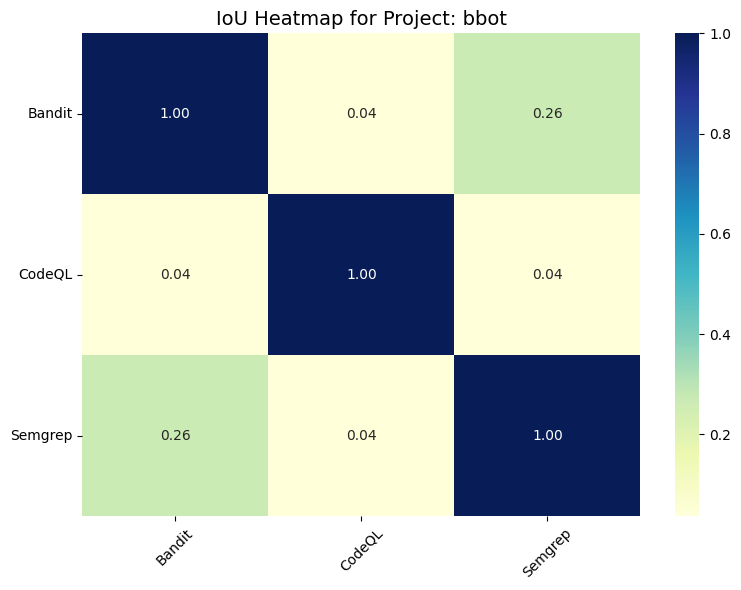

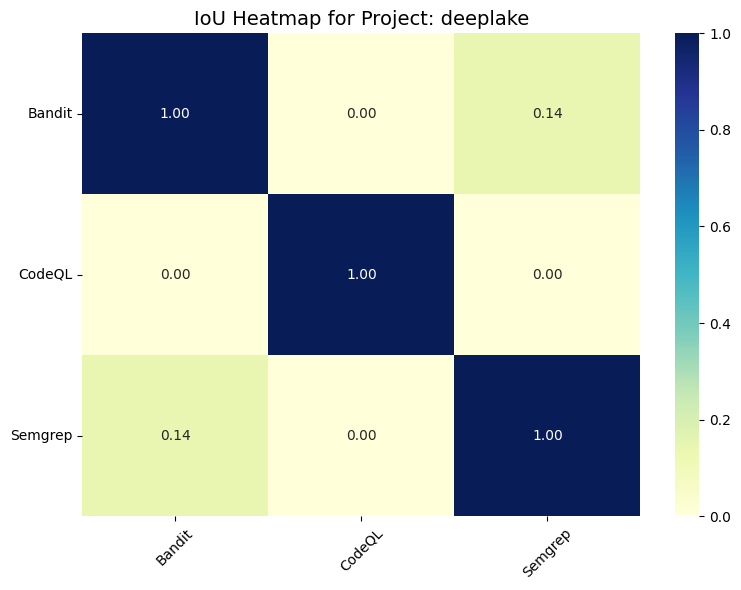

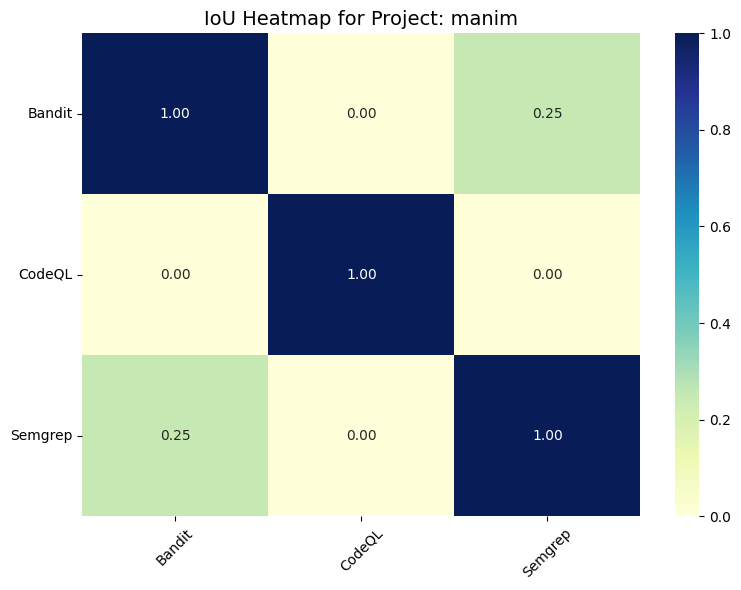

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read CSV
df = pd.read_csv("combined_results.csv")

# Unique projects and tools
projects = df["Project_name"].unique()
tools = df["Tool_name"].unique()

# IoU function
def iou(project, tool1, tool2):
    set1 = set(df[(df.Project_name == project) & (df.Tool_name == tool1)]["CWE_ID"])
    set2 = set(df[(df.Project_name == project) & (df.Tool_name == tool2)]["CWE_ID"])
    inter = set1 & set2
    union = set1 | set2
    return len(inter) / len(union) if union else 0

# Loop through each project and plot heatmap
for proj in projects:
    # Create IoU matrix
    matrix = []
    for t1 in tools:
        row = []
        for t2 in tools:
            row.append(iou(proj, t1, t2))
        matrix.append(row)
    
    # Convert to DataFrame
    iou_df = pd.DataFrame(matrix, index=tools, columns=tools)
    
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(iou_df, annot=True, cmap="YlGnBu", fmt=".2f", cbar=True)
    plt.title(f"IoU Heatmap for Project: {proj}", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


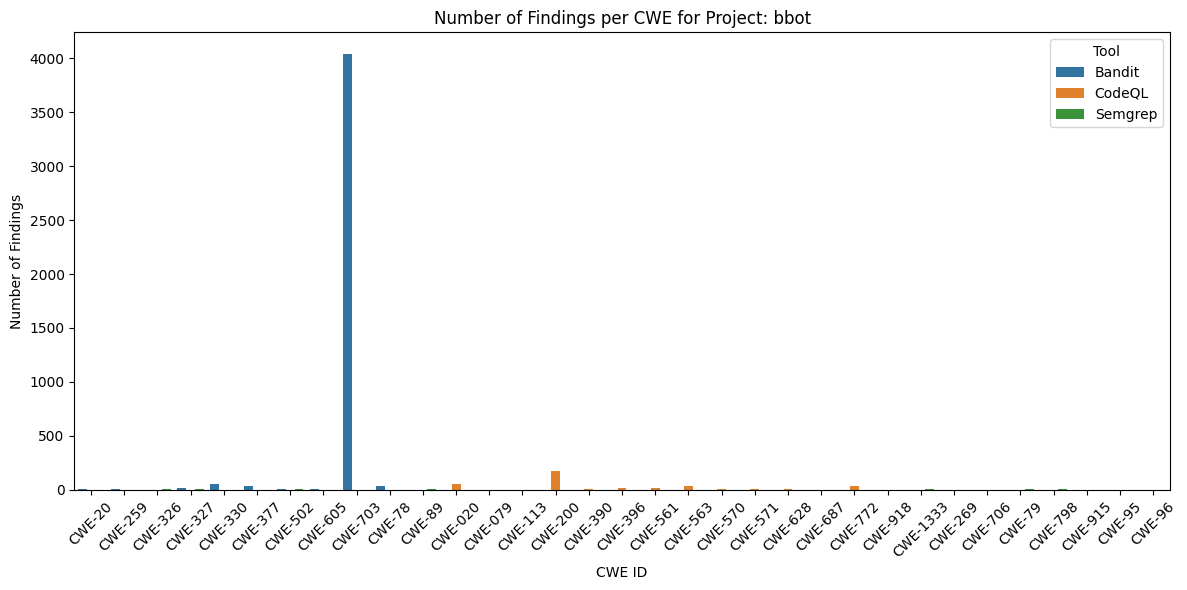

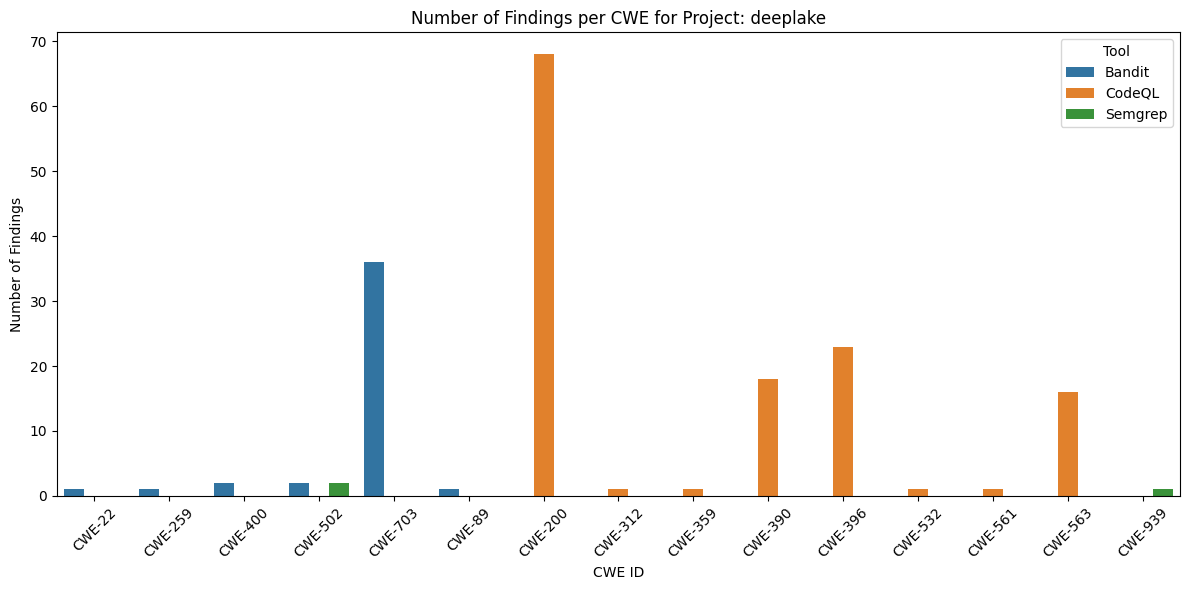

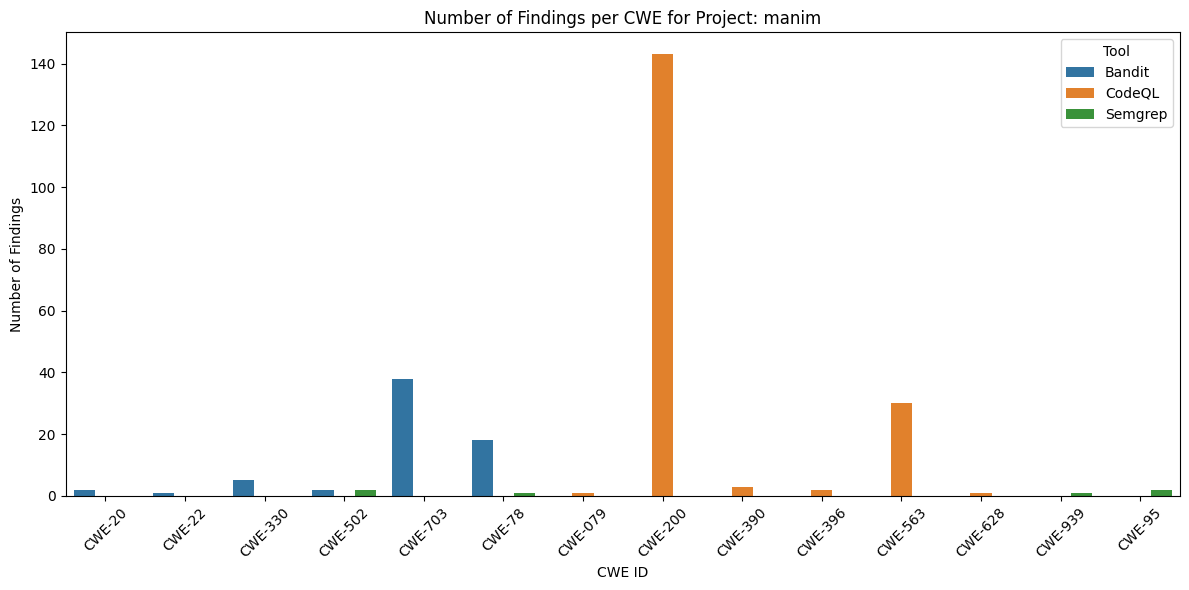

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Step 1: Load data
# -------------------------------
data = pd.read_csv("combined_results.csv")

# -------------------------------
# Step 2: List of projects
# -------------------------------
projects = data['Project_name'].unique()

# -------------------------------
# Step 3: Plot bar graph for each project
# -------------------------------
for project in projects:
    proj_data = data[data['Project_name'] == project]
    
    # Set figure size
    plt.figure(figsize=(12, 6))
    
    # Bar plot using seaborn
    sns.barplot(
        data=proj_data,
        x='CWE_ID',
        y='Number_of_Findings',
        hue='Tool_name'
    )
    
    # Customize plot
    plt.title(f'Number of Findings per CWE for Project: {project}')
    plt.ylabel('Number of Findings')
    plt.xlabel('CWE ID')
    plt.xticks(rotation=45)
    plt.legend(title='Tool')
    plt.tight_layout()
    
    # Show plot
    plt.show()


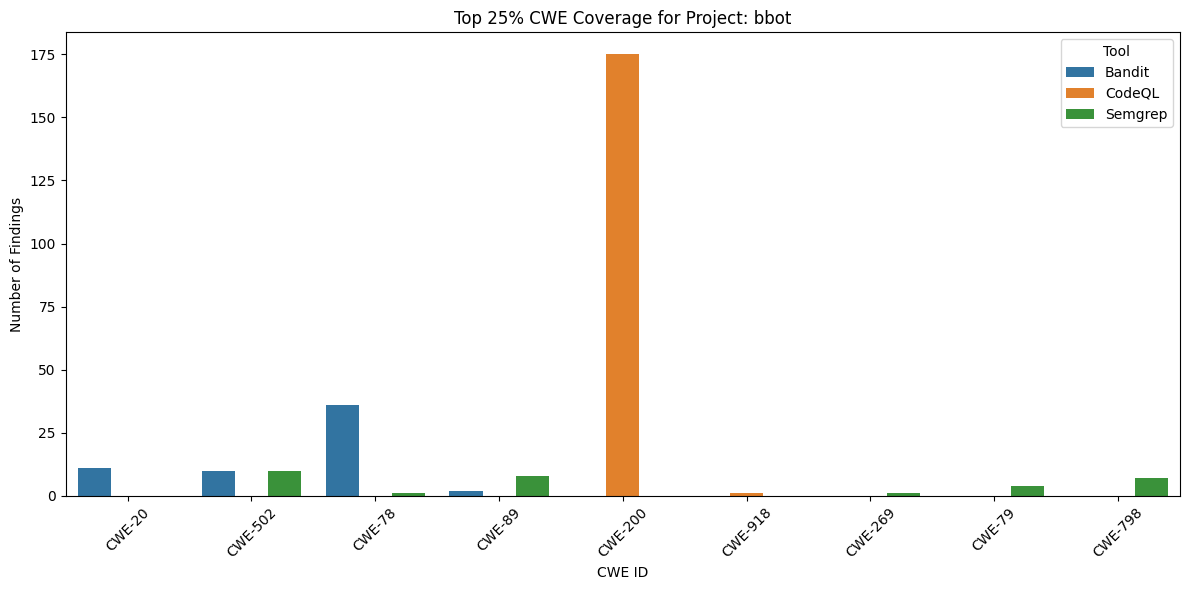

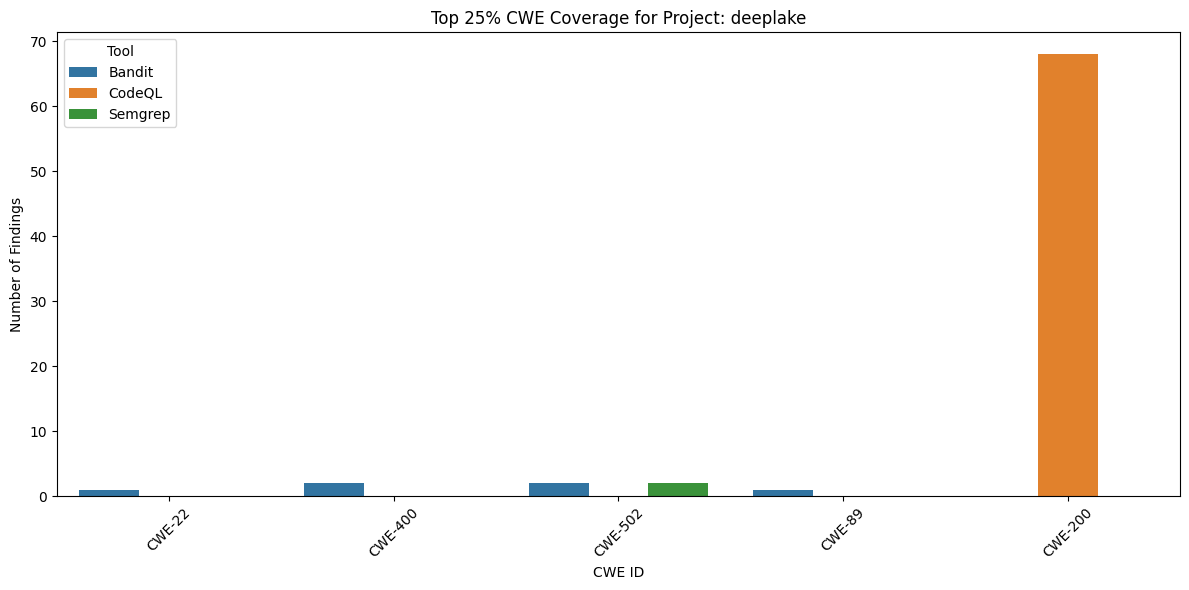

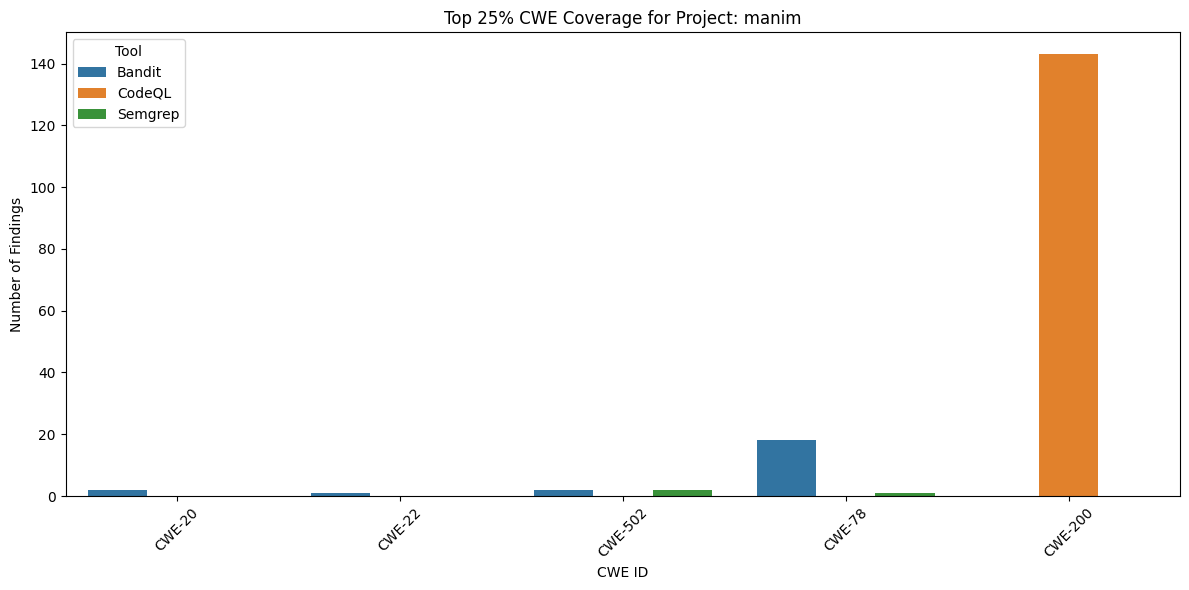

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Step 1: Load data
# -------------------------------
data = pd.read_csv("combined_results.csv")

# -------------------------------
# Step 2: Filter for Top 25% CWEs
# -------------------------------
top_cwe_data = data[data['Is_In_CWE_Top_25'] == 'Yes']

# -------------------------------
# Step 3: List of projects
# -------------------------------
projects = top_cwe_data['Project_name'].unique()

# -------------------------------
# Step 4: Plot bar graph for each project
# -------------------------------
for project in projects:
    proj_data = top_cwe_data[top_cwe_data['Project_name'] == project]
    
    plt.figure(figsize=(12, 6))
    
    sns.barplot(
        data=proj_data,
        x='CWE_ID',
        y='Number_of_Findings',
        hue='Tool_name'
    )
    
    plt.title(f'Top 25% CWE Coverage for Project: {project}')
    plt.ylabel('Number of Findings')
    plt.xlabel('CWE ID')
    plt.xticks(rotation=45)
    plt.legend(title='Tool')
    plt.tight_layout()
    plt.show()


Unique CWE IDs detected by each tool:
Bandit: 13 CWEs
CodeQL: 18 CWEs
Semgrep: 14 CWEs

Top 25 CWE Coverage (%) by Tool:
      Tool  Top25_CWE_Coverage
0   Bandit           54.545455
1   CodeQL           18.181818
2  Semgrep           54.545455


C:\Users\taksh\AppData\Local\Temp\ipykernel_22712\1516476738.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Tool', y='Top25_CWE_Coverage', data=coverage_df, palette="YlOrRd")


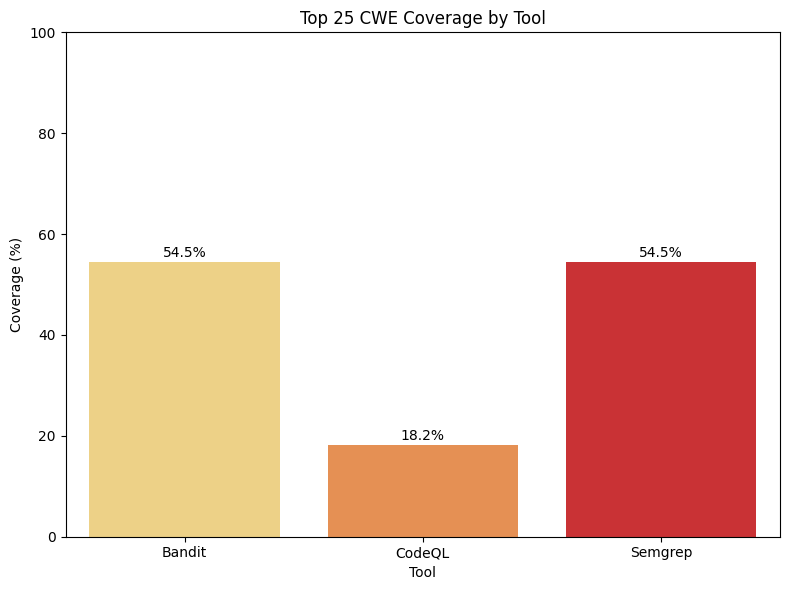

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Step 1: Load the CSV data
# -------------------------------
data = pd.read_csv("combined_results.csv")

# -------------------------------
# Step 2: Extract unique CWE IDs detected by each tool
# -------------------------------
tool_cwe_sets = data.groupby('Tool_name')['CWE_ID'].apply(set).to_dict()

print("Unique CWE IDs detected by each tool:")
for tool, cwes in tool_cwe_sets.items():
    print(f"{tool}: {len(cwes)} CWEs")

# -------------------------------
# Step 3: Compute Top 25 CWE coverage at tool level
# -------------------------------
# First, define which CWEs are in Top 25%
top_25_cwes = set(data[data['Is_In_CWE_Top_25'] == 'Yes']['CWE_ID'].unique())

tool_coverage = {}
for tool, cwes in tool_cwe_sets.items():
    top_cwe_found = cwes.intersection(top_25_cwes)
    coverage_percent = (len(top_cwe_found) / len(top_25_cwes)) * 100
    tool_coverage[tool] = coverage_percent

# Convert to DataFrame for plotting
coverage_df = pd.DataFrame(list(tool_coverage.items()), columns=['Tool', 'Top25_CWE_Coverage'])

print("\nTop 25 CWE Coverage (%) by Tool:")
print(coverage_df)

# -------------------------------
# Step 4: Visualize coverage
# -------------------------------
plt.figure(figsize=(8,6))
sns.barplot(x='Tool', y='Top25_CWE_Coverage', data=coverage_df, palette="YlOrRd")
plt.title('Top 25 CWE Coverage by Tool')
plt.ylabel('Coverage (%)')
plt.xlabel('Tool')
plt.ylim(0, 100)
for i, v in enumerate(coverage_df['Top25_CWE_Coverage']):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')
plt.tight_layout()
plt.show()


    Project     Tool  Top25_CWE_Coverage
0      bbot   Bandit           36.363636
1      bbot   CodeQL           18.181818
2      bbot  Semgrep           54.545455
3  deeplake   Bandit           36.363636
4  deeplake   CodeQL            9.090909
5  deeplake  Semgrep            9.090909
6     manim   Bandit           36.363636
7     manim   CodeQL            9.090909
8     manim  Semgrep           18.181818


C:\Users\taksh\AppData\Local\Temp\ipykernel_22712\1156692454.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Tool', y='Top25_CWE_Coverage', data=proj_df, palette="YlOrRd")


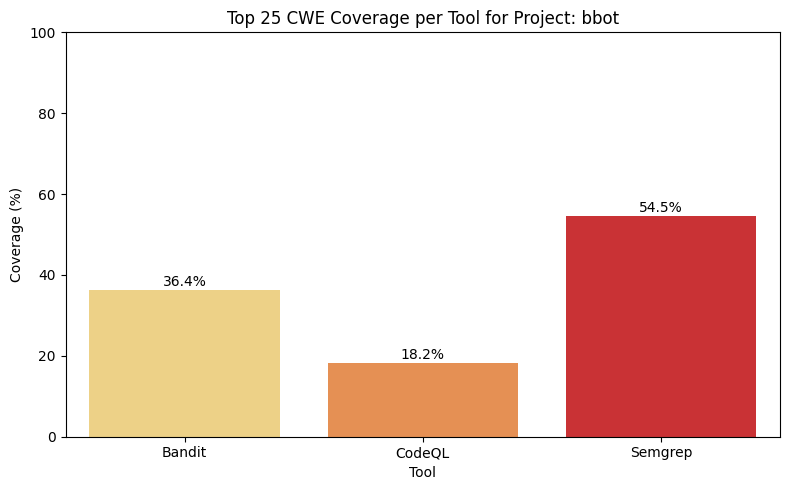

C:\Users\taksh\AppData\Local\Temp\ipykernel_22712\1156692454.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Tool', y='Top25_CWE_Coverage', data=proj_df, palette="YlOrRd")


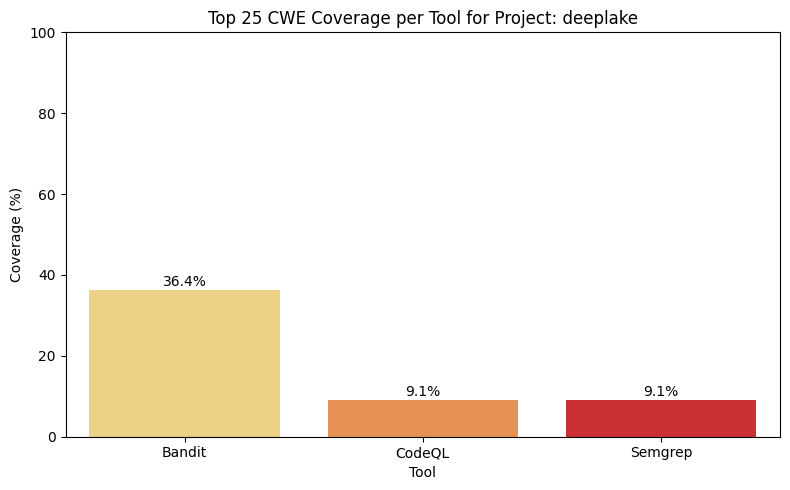

C:\Users\taksh\AppData\Local\Temp\ipykernel_22712\1156692454.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Tool', y='Top25_CWE_Coverage', data=proj_df, palette="YlOrRd")


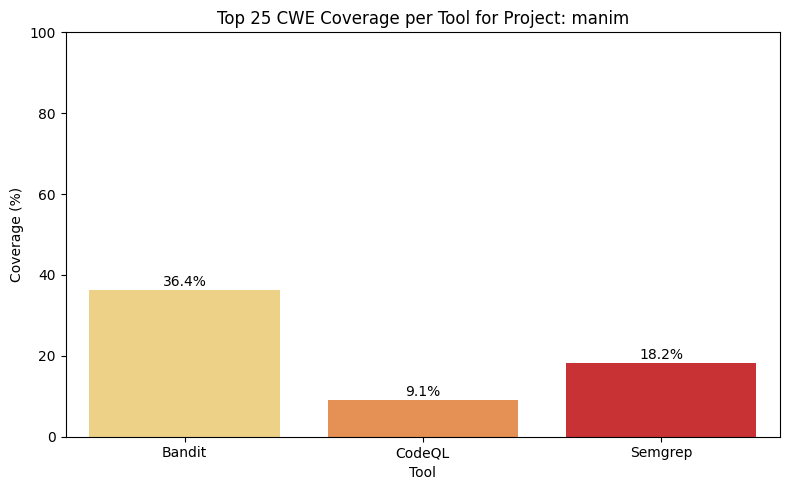

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Step 1: Load CSV data
# -------------------------------
data = pd.read_csv("combined_results.csv")

# -------------------------------
# Step 2: Identify Top 25 CWEs
# -------------------------------
top_25_cwes = set(data[data['Is_In_CWE_Top_25'] == 'Yes']['CWE_ID'].unique())

# -------------------------------
# Step 3: Compute Top 25 CWE coverage per tool per project
# -------------------------------
coverage_list = []

projects = data['Project_name'].unique()
for project in projects:
    proj_data = data[data['Project_name'] == project]
    tools = proj_data['Tool_name'].unique()
    
    for tool in tools:
        tool_cwes = set(proj_data[proj_data['Tool_name'] == tool]['CWE_ID'])
        top_found = tool_cwes.intersection(top_25_cwes)
        coverage_percent = (len(top_found) / len(top_25_cwes)) * 100
        coverage_list.append({
            'Project': project,
            'Tool': tool,
            'Top25_CWE_Coverage': coverage_percent
        })

coverage_df = pd.DataFrame(coverage_list)
print(coverage_df)

# -------------------------------
# Step 4: Plot bar graphs per project
# -------------------------------
for project in projects:
    proj_df = coverage_df[coverage_df['Project'] == project]
    
    plt.figure(figsize=(8,5))
    sns.barplot(x='Tool', y='Top25_CWE_Coverage', data=proj_df, palette="YlOrRd")
    plt.title(f'Top 25 CWE Coverage per Tool for Project: {project}')
    plt.ylabel('Coverage (%)')
    plt.ylim(0, 100)
    
    # Annotate percentages on bars
    for i, v in enumerate(proj_df['Top25_CWE_Coverage']):
        plt.text(i, v + 1, f"{v:.1f}%", ha='center')
    
    plt.tight_layout()
    plt.show()
